In [1]:
import os
import omdb
import csv
import pickle
import collections
import pandas as pd
print(pd.__version__)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from networkx.algorithms import clique
from networkx.algorithms import cluster
from networkx.algorithms import link_prediction
from networkx.algorithms import shortest_paths
from scipy.optimize import curve_fit
print(nx.__version__)

0.19.2
2.0


In [2]:
df = pickle.load(open("databasedump.pickle", 'rb'))


In [3]:
df.describe()

,actors,awards,box_office,country,director,genre,imdb_rating,imdb_votes,language,metascore,plot,production,rated,released,title,writer,year,title_director
count,15673,15673,15431,15673,15673,15673,15673,15673,15673,15673,15673,15431,15673,15673,15673,15673,15673,15673
unique,15267,2350,2900,1160,7035,949,82,10499,1338,98,14990,2089,23,8363,15646,13314,236,15673
top,N/A,N/A,N/A,USA,N/A,Drama,7.2,N/A,English,N/A,N/A,N/A,R,N/A,McDull: Me & My Mum,N/A,2004,Life: Daniel Espinosa
freq,231,5578,12402,8447,343,1153,683,350,9330,10322,667,3198,4584,653,2,870,538,1


In [4]:
#process dataframe into network
allActors = []
biGraph = nx.Graph()
actorSet = 0
movieSet = 1
count = 0

for index, row in df.iterrows():
    movie = row['title_director']
    biGraph.add_nodes_from([movie], bipartite=movieSet)
    actors = row['actors']
    if isinstance(actors, str):
        actors = actors.split(', ')
        #print(actors)
        for actor in actors:
            if not any(actor == name for name in allActors): # if actor is not in allActors already:
                allActors.append(actor)
                biGraph.add_nodes_from([actor], bipartite=actorSet)
                biGraph.add_edge(movie, actor, weight=1)
            else:
                biGraph.add_edge(movie, actor, weight=1)
    count = count + 1


In [6]:
if(len(biGraph.nodes) > 50):
    print('too many nodes to plot in a reasonable amount of time')
else:
    nx.draw(biGraph)
    plt.show()

too many nodes to plot in a reasonable amount of time


In [7]:
movieNodes = set(n for n, d in biGraph.nodes(data=True) if d['bipartite']==movieSet)
actorNodes = set(n for n, d in biGraph.nodes(data=True) if d['bipartite']==actorSet)
print(len(movieNodes))
print(len(actorNodes))

15674
27352


In [8]:
len(biGraph['Mickey Rooney'])

21

In [9]:
biGraph['Inception: Christopher Nolan']['Leonardo DiCaprio']['weight']

1

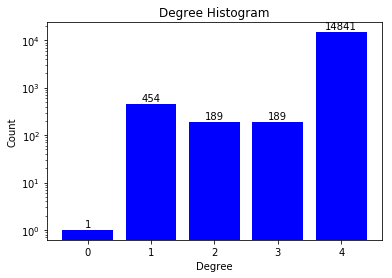

In [10]:
movieDegrees = sorted([d for n, d in biGraph.degree(movieNodes)])
#print(actorDegrees)
degreeCount = collections.Counter(movieDegrees)
degree, count = zip(*degreeCount.items())
fig, ax = plt.subplots()
bars = plt.bar(degree, count, width=0.80, color='b')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 1))

plt.show()

In [11]:
for actor in actorNodes:
    if biGraph.degree(actor) >= 45:
        print(actor + ": " + str(biGraph.degree(actor)))

Michael Caine: 54
John Wayne: 61
Nicolas Cage: 46
Bruce Willis: 48
Stan Laurel: 46
Robert De Niro: 63
James Stewart: 47
N/A: 231
Samuel L. Jackson: 48
Mel Blanc: 87
Oliver Hardy: 50


In [12]:
len(biGraph['N/A'])

231

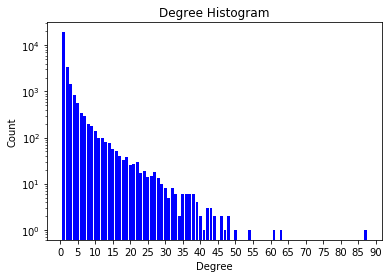

In [13]:
actorMovieDegrees = sorted([d for n, d in biGraph.degree(actorNodes)])
actorMovieDegrees = [i for i in actorMovieDegrees if i != len(biGraph['N/A'])]
#print(actorMovieDegrees)
degreeCount = collections.Counter(actorMovieDegrees)
degree, count = zip(*degreeCount.items())
fig, ax = plt.subplots()
bars = plt.bar(degree, count, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))

plt.show()

In [32]:
actorGraphUnweighted = nx.projected_graph(biGraph, actorNodes)
actorGraph = bipartite.weighted_projected_graph(biGraph, actorNodes)

In [15]:
print(actorGraph['James Franco']['Seth Rogen']['weight'])
print(len(actorGraph['James Franco']))

3
53


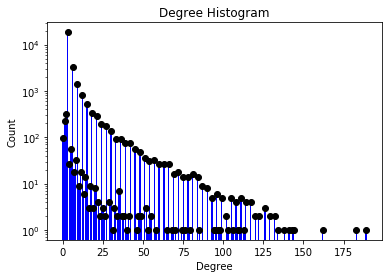

In [16]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degree, count = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(degree, count, width=0.80, color='b')
plt.plot(degree, count, 'ko')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


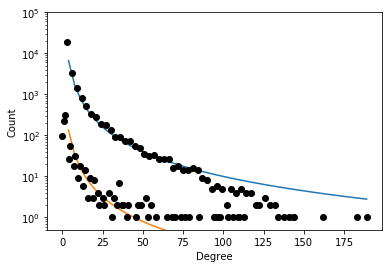

In [18]:
def func(x, a, b, c):
    return a*(x**-b) + c
    #return a*np.exp(-b*x)-c

#popt, pcov = curve_fit(func, degree, count, p0=(50000, 2, 1e-8), maxfev=50000)

xx = np.linspace(min(degree), max(degree))
yy = func(xx, 100000, 2, 0)
yyy = func(xx, 2000, 2, 0)
#yy = func(xx, *popt)

plt.plot(xx, yy)
plt.plot(xx, yyy)
plt.plot(degree, count, 'ko')
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Degree")

plt.ylim([0.5, 10e4])
plt.show()

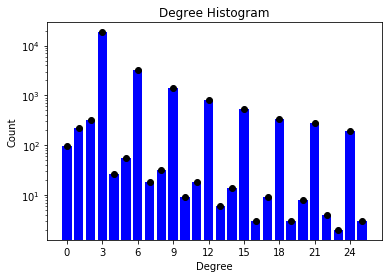

In [30]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
actorDegrees = [i for i in actorDegrees if i <=25]
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degree, count = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(degree, count, width=0.80, color='b')
plt.plot(degree, count, 'ko')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 3))

plt.show()

Counter({3: 18552, 6: 3251, 9: 1394, 12: 820, 15: 527, 18: 334, 21: 282, 24: 192, 27: 177, 30: 136, 33: 93, 36: 91, 42: 75, 39: 74, 45: 56, 48: 49, 51: 36, 57: 33, 54: 31, 63: 27, 66: 27, 60: 26, 72: 18, 69: 16, 81: 16, 75: 14, 78: 14, 84: 14, 87: 9, 90: 8, 96: 6, 93: 5, 99: 5, 105: 5, 111: 5, 108: 4, 114: 4, 117: 4, 126: 3, 102: 2, 120: 2, 129: 2, 132: 2, 138: 1, 141: 1, 144: 1, 162: 1, 183: 1, 189: 1})


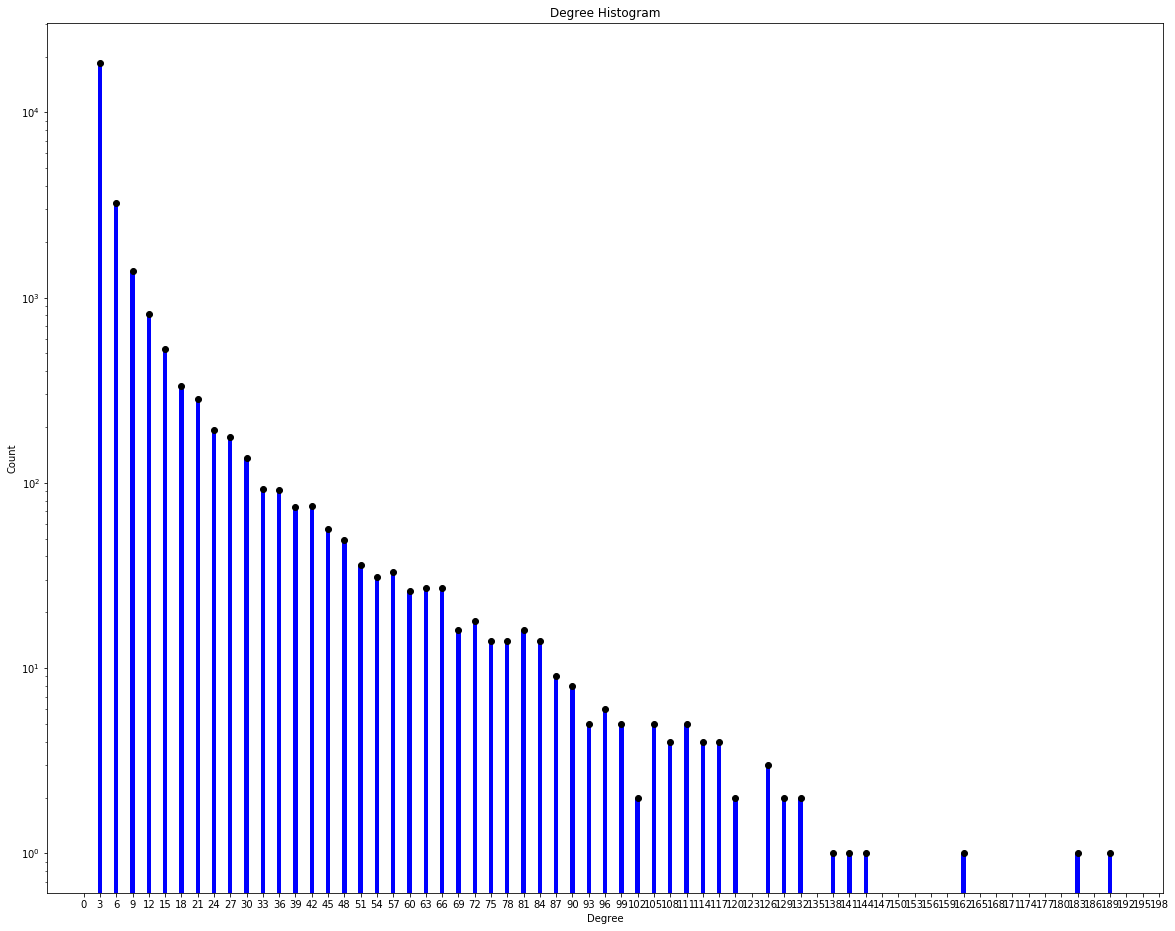

In [58]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
#actorDegrees = [i for i in actorDegrees if (i >=25) & (i < 50)]
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degreeCount3 = collections.Counter()
degreeCountOth = collections.Counter()
for deg in degreeCount:
    if (deg % 3 == 0) & (deg != 0):
        #print(deg)
        degreeCount3.update({deg:degreeCount[deg]})
    else:
        degreeCountOth.update()
        

#print(elem, degreeCount[elem])
print(degreeCount3)
degree, count = zip(*degreeCount3.items())
#degree = degree[::3]
#count = count[::3]
#degree3 = [deg for deg in degree if deg % 3 == 0]


fig, ax = plt.subplots(figsize=(20,16))
plt.bar(degree, count, width=0.80, color='b')
plt.plot(degree, count, 'ko')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 3))

plt.show()

[ -2.43711740e+00   2.69280958e+05   2.43454553e+01]
[[  3.64189979e-04  -1.09716767e+02  -5.31982687e-02]
 [ -1.09716767e+02   3.36533355e+07   1.48786723e+04]
 [ -5.31982687e-02   1.48786723e+04   6.79622917e+01]]
0.9996196521532349


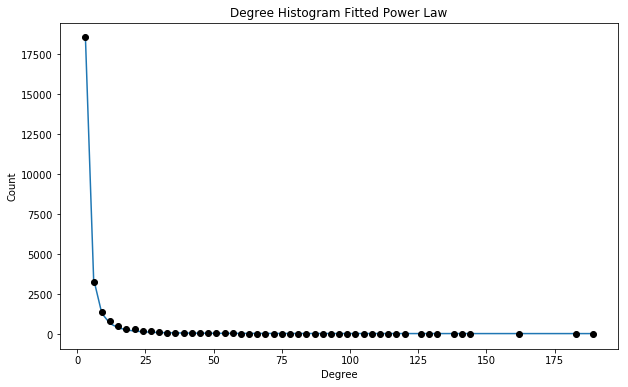

In [81]:
df = pd.DataFrame({
            'degree': degree,
            'count': count
        })
#df.plot(x='degree', y='count', kind='line', style='--ro')

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

target_func = func_powerlaw

X = df['degree']
y = df['count']

popt, pcov = curve_fit(target_func, X, y, maxfev=3000, p0 = np.asarray([-1, 10*5, 0])) 
print(popt)
print(pcov)

residuals = y - target_func(X, popt[0], popt[1], popt[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

#plt.figure(figsize=(20, 16))
#plt.plot(X, target_func(X, *popt), '-')
#plt.plot(X, y, 'ro')

#plt.legend()
#plt.show()

fig, ax = plt.subplots(figsize=(10,6))
#plt.bar(degree, count, width=0.80, color='b')
plt.plot(X, target_func(X, *popt), '-')
plt.plot(X, y, 'ko')

plt.title("Degree Histogram Fitted Power Law")
plt.ylabel("Count")
plt.xlabel("Degree")
#equation = r'$P(k) = ' + str(round(popt[1], 3)) + '* x^' + str(round(popt[0], 3) + ' + '+ str(round(popt[2], 3))
#text(1,1, equation)
#start, end = ax.get_xlim()
#ax.xaxis.set_ticks(np.arange(0, end, 3))

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


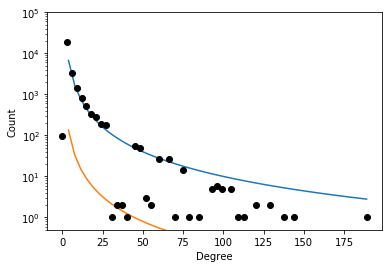

In [19]:
#degree3 = degree[::3]
#count3 = count[::3]

xx = np.linspace(min(degree), max(degree))
yy = func(xx, 100000, 2, 0)
#yyy = func(xx, 2000, 2, 0)
#yy = func(xx, *popt)

plt.plot(xx, yy)
#plt.plot(xx, yyy)
plt.plot(degree3, count3, 'ko')
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Degree")

plt.ylim([0.5, 10e4])
plt.show()

In [ ]:
allPairs = dict(nx.all_pairs_shortest_path_length(actorGraph))

In [ ]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degree, count = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(degree, count, width=0.80, color='b')
plt.plot(degree, count, 'ko')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))

plt.show()